# PyTorch: Nonlinear Equalizer

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

$x_i \in \mathcal{X} = \{-3, -1, 1, 3\}$ is a sequence of 4-ASK transmitted symbols. The channel introduces nonlinear effects, noise, and inter-symbol-interference (ISI).
We wish to train a neural network that can revert the channel effects and estimate the transmitted symbols $\hat{x_i}$ form the channel outputs $y_i$ with smallest symbols error rate (SER).

Loading the transmitted and received samples and plotting them on histograms.

In [2]:
# Load data
x = np.loadtxt('data/x_nleq.txt')
y = np.loadtxt('data/y_nleq.txt')
# Alphabet
alphabet = np.array([-3., -1., 1., 3.])  # alphabet
alphabet = alphabet /  np.sqrt(np.mean(np.abs(alphabet**2)))  # normalization

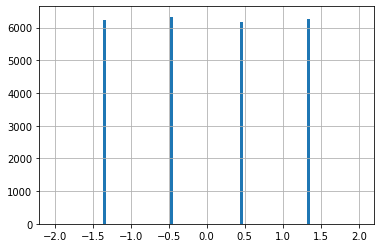

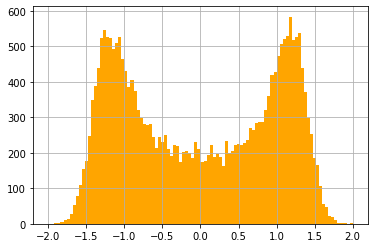

In [3]:
# Visualize your data
plt.hist(x, bins=100, range=[-2, 2])
plt.grid()
plt.show()
plt.hist(y, bins=100, range=[-2, 2], color='orange')
plt.grid()

Splitting the data into train and test set.

In [4]:
# Split the data into train and test
n = 15_000
x_train = x[0:n]
y_train = y[0:n]
x_test = x[n:]
y_test = y[n:]

Defining the neural network equalizer. It takes the channel output $y_i$ as input and returns an estimate of the respective transmit symbol $\hat{x_i}$.

In [6]:
class NonLinearEq(nn.Module):
    def __init__(self, taps=1, n=20): 
        super().__init__()
        self.h1 = nn.Linear(taps,n)
        self.act1 = nn.ReLU()
        self.h2 = nn.Linear(n,n)
        self.act2 = nn.ReLU()
        self.h3 = nn.Linear(n,n)
        self.act3 = nn.ReLU()
        self.out = nn.Linear(n,1)

    def forward(self, y):
        y = self.act1(self.h1(y))
        y = self.act2(self.h2(y))
        y = self.act3(self.h3(y))
        return self.out(y)

Definition of NN training function.

In [7]:
def train(NeuralNetwork,dataloader,loss_function, num_epochs, lr=0.001):
    """
    Performs gradient descent learning.
    
    NeuralNetwork = neural network to be trained
    dataloader = DataLoader that deals batches for mini-batch learning
    loss_function = cost function to be optimized
    num_epochs = number of training epochs
    lr = learning rate (default value 0.001)
    """
    optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr = lr)
    for epoch in range(num_epochs):
        for inputs,labels in dataloader:
            # forward propagation
            outputs = NeuralNetwork(inputs)
            # compute loss
            loss = loss_function(outputs, labels)
            # reset gradient
            optimizer.zero_grad()
            # backprop
            loss.backward()
            # update parameters
            optimizer.step()

        if (epoch % 100) == 0:
            print('Epoch: ',epoch, 'Loss: ', loss.detach().numpy())

Preparing the data for the training, i.e. convert the numpy array into tensor and creating a dataloader.

In [8]:
# convert x_D, y_D to tensors
y_t = torch.tensor(y_train).float().reshape(-1, 1)
x_t = torch.tensor(x_train).float().reshape(-1, 1)
# Dataset
dataset = torch.utils.data.TensorDataset(y_t, x_t)
# Dataloader
batch_size = 2000
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

Initializing and training the network.

In [9]:
# Initialize Network
torch.manual_seed(0)
eq_nl = NonLinearEq()
# Training
train(eq_nl,dataloader,nn.MSELoss(), 500, 0.01)

Epoch:  0 Loss:  0.42640382
Epoch:  100 Loss:  0.2949423
Epoch:  200 Loss:  0.2981015
Epoch:  300 Loss:  0.29714453
Epoch:  400 Loss:  0.2968098


Displaying output of the untrained NN.

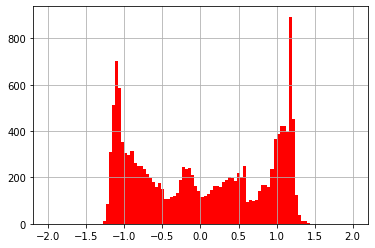

In [58]:
# Visualize your results
x_hat = eq_nl(y_t).detach().numpy()
plt.hist(x_hat, bins=100, range=[-2, 2], color='red')
plt.grid()

Definition of hard-decision demapping function. Given the values from $\boldsymbol{y}$ or $\boldsymbol{\hat{x}}$ it returns the closest value from the alphabet.

In [59]:
def hard_demapper(msg, alphabet):
    idxs = np.argmin(np.abs(msg.reshape(-1,1)-alphabet), axis=1)
    hard_decision = alphabet[idxs]
    return hard_decision

In [60]:
# SER
hard_y = hard_demapper(y_train, alphabet)
hard_xhat = hard_demapper(x_hat, alphabet)
print(f'SER before equalization: {sum(x_train!=hard_y)/x_train.size:.2f}')
print(f'SER after equalization: {sum(x_train!=hard_xhat)/x_train.size:.2f}')

SER before equalization: 0.38
SER after equalization: 0.38


In [61]:
# Test dataset
hard_y_test = hard_demapper(y_test, alphabet)
print(f'SER before equalization: {sum(x_test!=hard_y_test)/x_test.size:.2f}')
y_t_test = torch.tensor(y_test.T).float().reshape(-1, 1)
x_hat_test = eq_nl(y_t_test).detach().numpy()
hard_xhat_test = hard_demapper(x_hat_test, alphabet)
print(f'SER after equalization: {sum(x_test!=hard_xhat_test)/x_test.size:.2f}')

SER before equalization: 0.37
SER after equalization: 0.39


The channel under study causes ISI. Therefore we need an equalizer that does not only take one channel output $y_i$ to calculate $\hat{x_i}$ but we need a number $t$ of channel taps $y_{i-\frac{t}{2}} \dots y_i \dots y_{i+\frac{t}{2}}$. 

The channel taps will enter the equalizer in a sliding window fashion.
In order to do so  write a function `getchunks(y, num\_taps)` that transforms your input tensor $\boldsymbol{y}$ from a size $[n,1]$ to size $[n, t]$, where t is the number of taps. 
Each row contains $t$ channel taps and the current symbol sits in the middle. The following row is a shift of the previous one (use `torch.roll`).

In [62]:
def getchunks(x, num_taps=17):
    x = x.reshape(-1, 1)
    chunks = torch.zeros(x.shape[0], num_taps)
    for j in range(num_taps):
        chunks[:, j:j+1] = torch.roll(x, j - num_taps//2)
    return chunks

Repeating the previous steps using the \textit{getchunks(y, num\_taps)} function and modifying the neural network such that it takes as input $t$ channel outputs.

In [63]:
# Initialize Network
taps = 17
eq_nl_taps = NonLinearEq(taps)
# convert x_D, y_D to tensors
y_t = torch.tensor(y_train.T).float().reshape(-1, 1)
x_t = torch.tensor(x_train.T).float().reshape(-1, 1)
# Dataset
dataset = torch.utils.data.TensorDataset(getchunks(y_t), x_t)
# Dataloader
batch_size = 5000
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [64]:
train(eq_nl_taps,dataloader,nn.MSELoss(), 500, 0.01)

Epoch:  0 Loss:  0.9402796
Epoch:  100 Loss:  0.082511276
Epoch:  200 Loss:  0.0744882
Epoch:  300 Loss:  0.069748364
Epoch:  400 Loss:  0.0689169


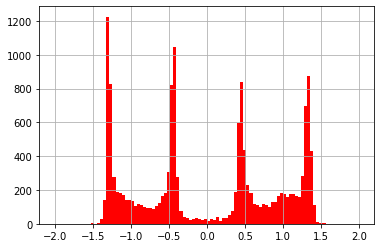

In [65]:
# Visualize your results
x_hat = eq_nl_taps(getchunks(y_t)).detach().numpy()
plt.hist(x_hat, bins=100, range=[-2, 2], color='red')
plt.grid()

In [66]:
# SER
hard_xhat = hard_demapper(x_hat, alphabet)
print(f'SER before equalization: {sum(x_train!=hard_y)/x_train.size:.2f}')
print(f'SER after equalization: {sum(x_train!=hard_xhat)/x_train.size:.2f}')

SER before equalization: 0.38
SER after equalization: 0.11


In [67]:
# Test dataset
x_hat_test = eq_nl_taps(getchunks(y_t_test)).detach().numpy()
hard_xhat_test = hard_demapper(x_hat_test, alphabet)
print(f'SER before equalization: {sum(x_test!=hard_y_test)/x_test.size:.2f}')
print(f'SER after equalization: {sum(x_test!=hard_xhat_test)/x_test.size:.2f}')

SER before equalization: 0.37
SER after equalization: 0.15
